In [168]:
import pandas as pd 
import numpy as np 
import plotly.express as px
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.distributions.empirical_distribution import ECDF
import datetime
import seaborn as sns

import matplotlib.dates as md
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
import math

import statsmodels.api as sm 
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from fbprophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

plt.style.use(['fast', 'dark_background'])

In [136]:
data = pd.read_csv('model_data.csv')
data.sort_values(by = ['Date'], inplace = True)
data.head()

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,quarter,weekday,year,month,day,week_of_year,day_of_year,day_of_week,IsStateHoliday,Day
1017208,2013-01-01,1115,2,0,0,0,0,a,1,d,...,1,1,2013,1,1,1,1,1,1,Weekday
264185,2013-01-01,291,2,0,0,0,0,a,1,d,...,1,1,2013,1,1,1,1,1,1,Weekday
444769,2013-01-01,487,2,0,0,0,0,a,1,d,...,1,1,2013,1,1,1,1,1,1,Weekday
874305,2013-01-01,959,2,0,0,0,0,a,1,a,...,1,1,2013,1,1,1,1,1,1,Weekday
590543,2013-01-01,648,2,0,0,0,0,a,1,d,...,1,1,2013,1,1,1,1,1,1,Weekday


In [137]:
data = pd.get_dummies(data, columns = ['StateHoliday','StoreType', 'Assortment'])
data.head()

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,...,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
1017208,2013-01-01,1115,2,0,0,0,0,1,5350,11,...,1,0,0,0,0,0,1,0,0,1
264185,2013-01-01,291,2,0,0,0,0,1,540,7,...,1,0,0,0,0,0,1,1,0,0
444769,2013-01-01,487,2,0,0,0,0,1,2180,9,...,1,0,0,0,0,0,1,0,0,1
874305,2013-01-01,959,2,0,0,0,0,1,1060,12,...,1,0,0,1,0,0,0,0,0,1
590543,2013-01-01,648,2,0,0,0,0,1,2130,12,...,1,0,0,0,0,0,1,1,0,0


In [177]:
# Store 1 only 
y = df.loc[(df.Store == 1)]
y['Date'] = pd.to_datetime(y['Date'], 
                           infer_datetime_format = True)
y.head()

AttributeError: 'DataFrame' object has no attribute 'Store'

In [ ]:
x = pd.DataFrame(columns = [['Date', 'Sales']])
x['Date'] = y['Date']
x['Sales'] = y['Sales']

#x.to_csv('sales_store1.csv', index = False)

In [ ]:
df = pd.read_csv('sales_store1.csv')

df['Date'] = pd.to_datetime(df['Date'],
                           infer_datetime_format = True)

x = df.set_index(['Date'])
x.head()

In [ ]:
def test_stationarity(timeseries):
    
    # Determine rolling stats
    MA = timeseries.rolling(window = 12).mean() # 12 months 
    MSTD = timeseries.rolling(window = 12).std()
    
    # Plot rolling stats
    plt.figure(figsize = (27,9))
    sns.despine(left = True)
    orig = plt.plot(timeseries, color = 'purple',label='Original')
    mean = plt.plot(MA, color='gold', label='Rolling Mean')
    std = plt.plot(MSTD, color='red', label = 'Rolling Std')

    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block = False)
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
   
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        
    print(dfoutput)

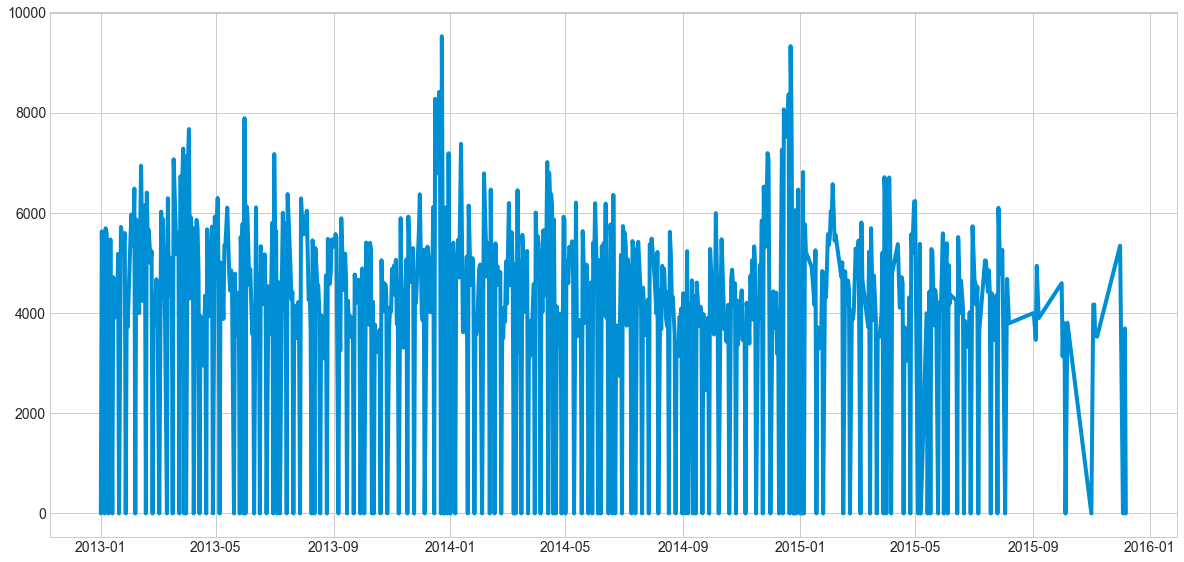

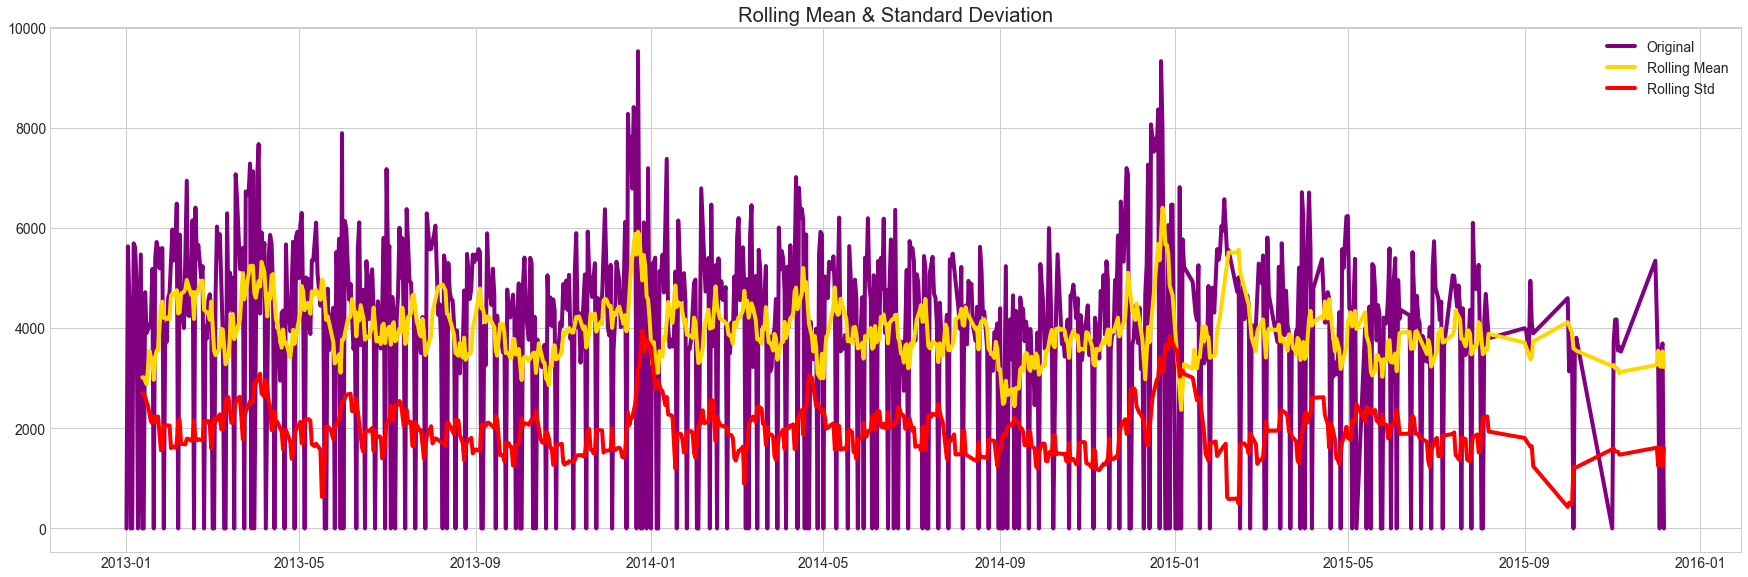

<Results of Dickey-Fuller Test>
Test Statistic                -1.070294e+01
p-value                        3.485594e-19
#Lags Used                     6.000000e+00
Number of Observations Used    9.350000e+02
Critical Value (1%)           -3.437363e+00
Critical Value (5%)           -2.864636e+00
Critical Value (10%)          -2.568419e+00
dtype: float64


In [219]:
ts = x['Sales']

ts['2013-01-01']

from datetime import datetime
ts[datetime(2013, 1, 1)]

plt.plot(ts)
plt.show()
test_stationarity(ts)

### Rolling mean and Rolling std must be constant over time for ts to be stationary

- seems stationary 

In [ ]:
# Possibe improvement in stats 
    # log scale transformation exponential decay transformation
        # halflife = 12 (12 months)
        # window = 12
        
log_ts = np.log(ts)

log_ts = log_ts.replace([np.inf, -np.inf], np.nan)
log_ts.dropna(inplace = True)
log_ts.head()

# averaging over last 365 values (1 year)
movingAVG = log_ts.rolling(window = 365).mean()
# movingSTD = log_ts.rolling(window = 365).std()

#plt.plot(log_ts, color = 'purple'); 
#plt.plot(movingAVG, color = 'red'); 

In [ ]:
log_ts_MA_diff = log_ts - movingAVG 
log_ts_MA_diff.dropna(inplace = True)
test_stationarity(log_ts_MA_diff)

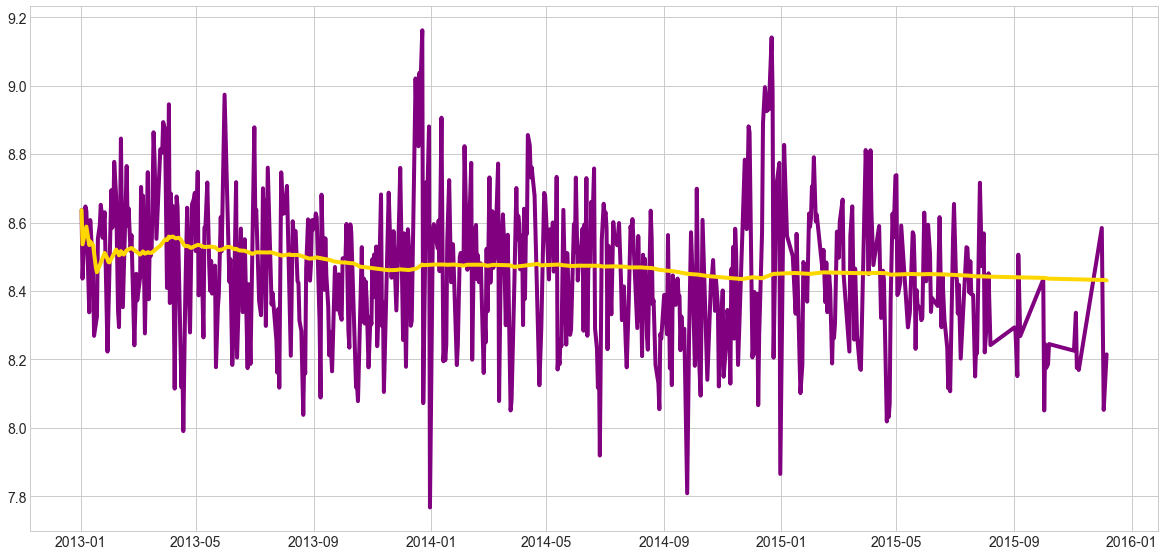

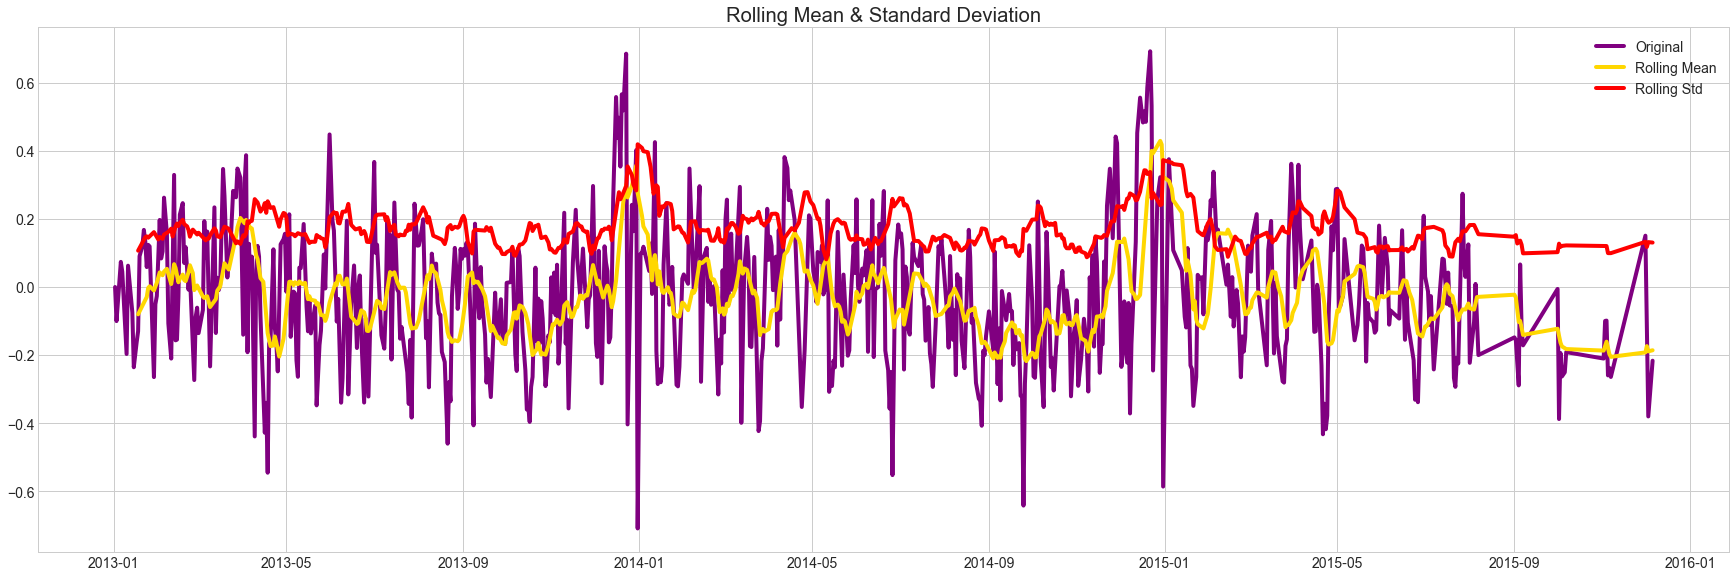

<Results of Dickey-Fuller Test>
Test Statistic                -1.029474e+01
p-value                        3.495089e-18
#Lags Used                     4.000000e+00
Number of Observations Used    7.760000e+02
Critical Value (1%)           -3.438805e+00
Critical Value (5%)           -2.865272e+00
Critical Value (10%)          -2.568757e+00
dtype: float64


In [222]:
# Exponential decay transformation 
exp_wavg = log_ts.ewm(halflife = 365).mean()

plt.plot(log_ts, color = 'purple')
plt.plot(exp_wavg, color = 'gold')
log_ts_ewa_diff = log_ts - exp_wavg
# log_ts_ewa_diff.head()

test_stationarity(log_ts_ewa_diff)

Date
2013-01-02         NaN
2013-01-03   -0.200197
2013-01-06    0.210793
2013-01-07   -0.013974
2013-01-08   -0.117026
Name: Sales, dtype: float64


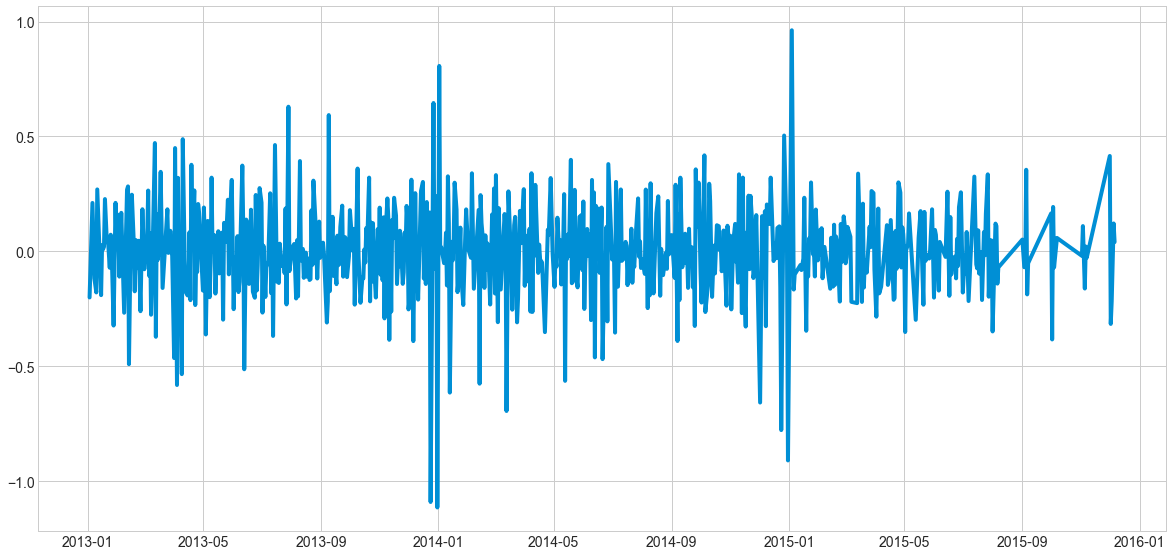

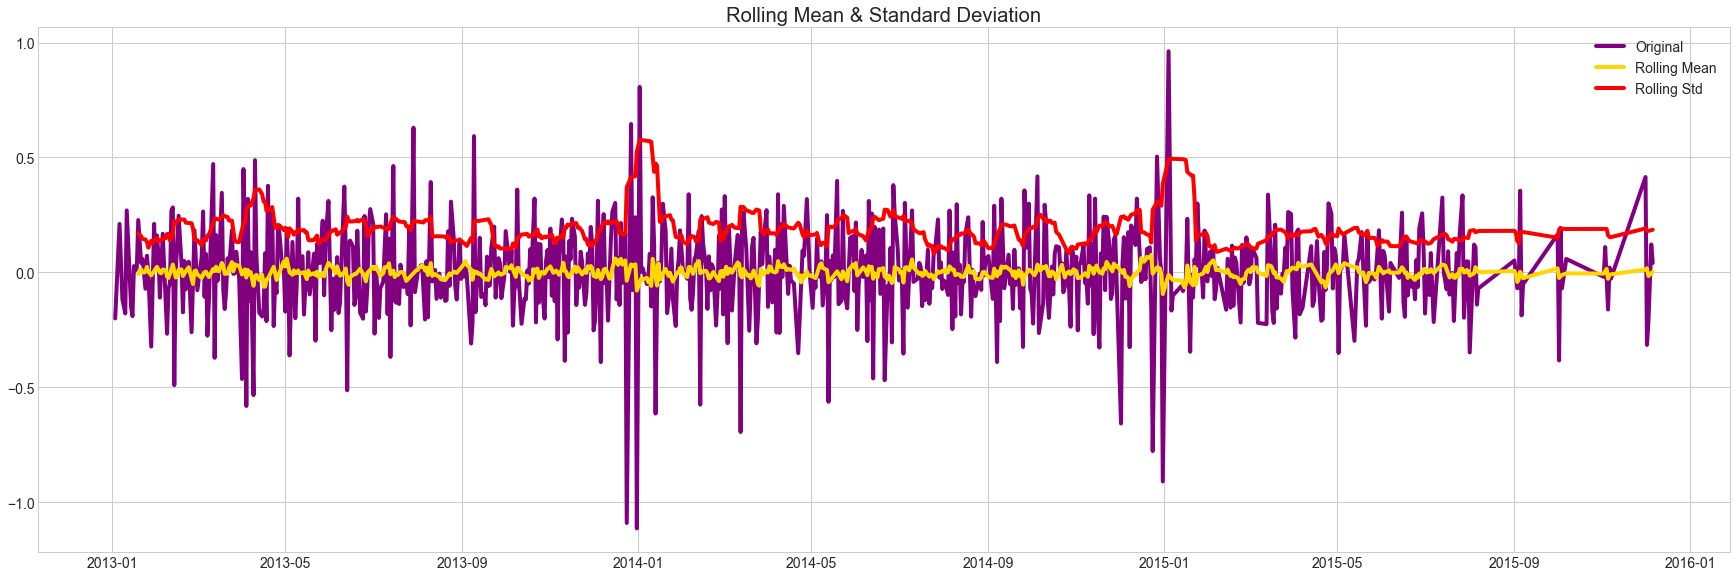

<Results of Dickey-Fuller Test>
Test Statistic                -1.125480e+01
p-value                        1.677445e-20
#Lags Used                     2.100000e+01
Number of Observations Used    7.580000e+02
Critical Value (1%)           -3.439006e+00
Critical Value (5%)           -2.865361e+00
Critical Value (10%)          -2.568804e+00
dtype: float64


In [224]:
# Differencing 
    # time shift 
    
log_ts_diff = log_ts - log_ts.shift()
print(log_ts_diff.head())
plt.plot(log_ts_diff)

log_ts_diff.dropna(inplace = True)
test_stationarity(log_ts_diff)

### TS is stationary 
- MA & MSTD is almost parallel to x-axis, have no trend 
- current datetime data is awkward, use average daily sales for month 

C:\Users\ke117\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning:

how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)



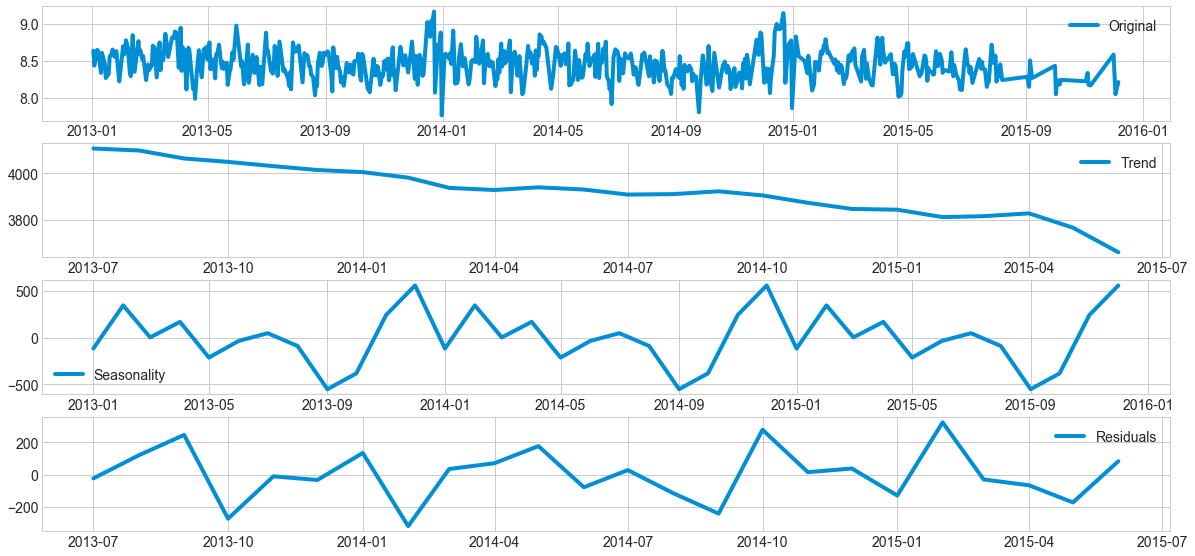

In [225]:
# x = x.resample('m', how = np.sum)

z = log_ts.resample('m', how = np.sum) # resample over month 
z.head()
#x.isnull().count()
decomp = sm.tsa.seasonal_decompose(y)

trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid 

plt.subplot(411)
plt.plot(log_ts, label = 'Original')
plt.legend(loc = 'best')

plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')

plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc = 'best')

plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')

### ACF & PACF 

C:\Users\ke117\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



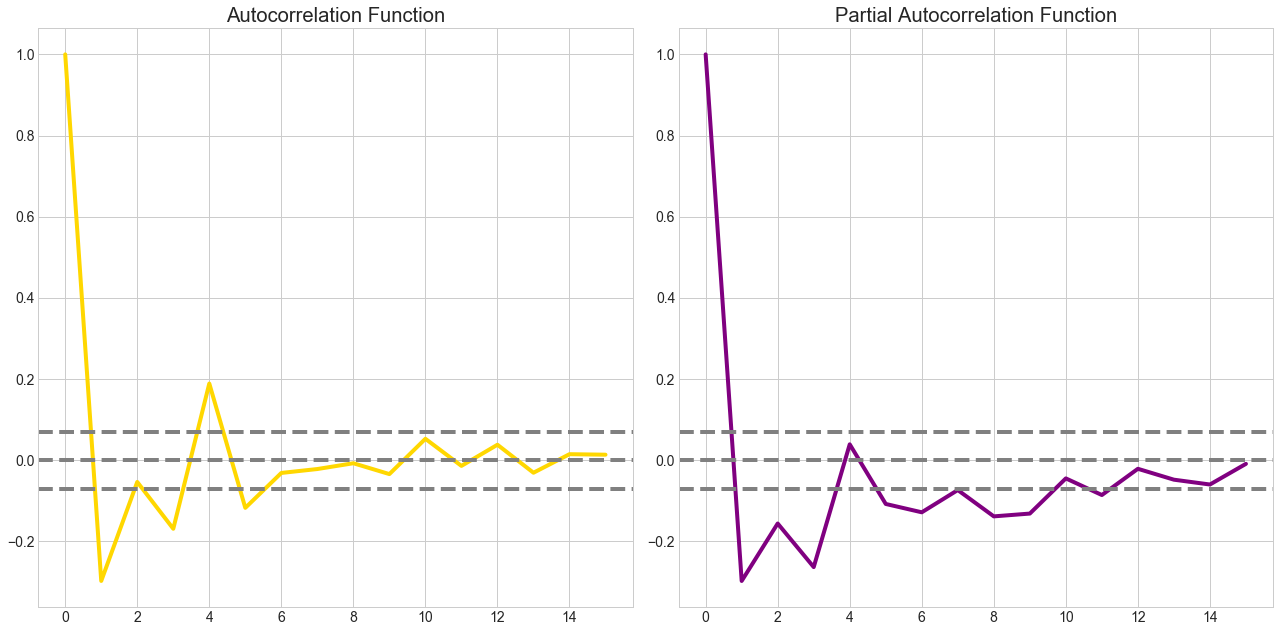

In [226]:
lag_acf = acf(log_ts_diff, nlags = 15)
lag_pacf = pacf(log_ts_diff, nlags = 15, method = 'ols')

plt.subplot(121)
plt.plot(lag_acf, color = 'gold')
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(log_ts_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(log_ts_diff)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf, color = 'purple')
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(log_ts_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(log_ts_diff)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()   

### Gray lines = significance limits, indicate correlation at that lag != 0 

- Significant correlations at the first few lags, followed by insignificant correlations 

- Number of significant correlations indicate order of the autoregressive term 

# ARIMA 
 
- order = (p, d, q) 

- ACF plot shows y = 0.0 when x = 4.5 (approx), thus q = 4.5 ?

- PACF plot shows y = 0.0 when x = 2.5 (approx), thus p = 2.5 ?

C:\Users\ke117\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\ke117\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\ke117\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\ke117\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\ke117\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date inde

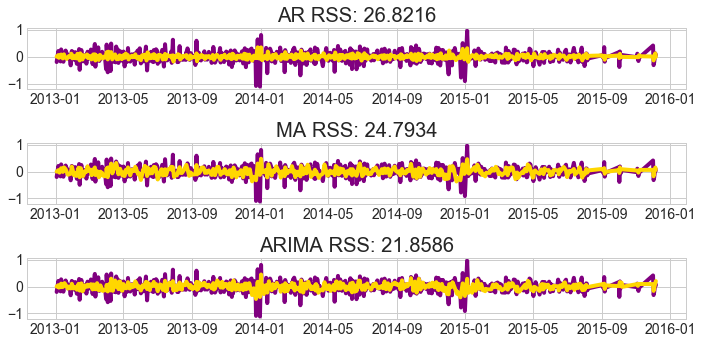

In [233]:
# AR model 
plt.figure(figsize = (10, 5))
AR_model = ARIMA(log_ts, 
                 order = (2, 1, 0))

AR_results = AR_model.fit(disp = -1)

plt.subplot(3, 1, 1)
plt.plot(log_ts_diff, color = 'purple')
plt.plot(AR_results.fittedvalues, color = 'gold')

plt.title('AR RSS: %.4f'%sum((AR_results.fittedvalues - log_ts_diff)**2))

# MA model
MA_model = ARIMA(log_ts, 
                 order = (0, 1, 2))

MA_results = MA_model.fit(disp = -1)

plt.subplot(3, 1, 2)
plt.plot(log_ts_diff, color = 'purple')
plt.plot(MA_results.fittedvalues, color = 'gold');

plt.title('MA RSS: %.4f'%sum((MA_results.fittedvalues - log_ts_diff)**2))

# ARIMA 
ARIMA_model = ARIMA(log_ts, 
                 order = (4, 1, 6))

ARIMA_results = ARIMA_model.fit(disp = -1)

plt.subplot(3, 1, 3)
plt.plot(log_ts_diff, color = 'purple')
plt.plot(ARIMA_results.fittedvalues, color = 'gold');

plt.title('ARIMA RSS: %.4f'%sum((ARIMA_results.fittedvalues - log_ts_diff)**2))
plt.tight_layout();

Combining AR & MA decreases errors

# Grid search 

import itertools
p = d = q = range(0, 2)

pdq = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))] 
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

In [323]:
y = x['Sales'].resample('MS').mean()
mod = sm.tsa.statespace.SARIMAX(y,
                               order = (4, 1, 2),
                               seasonal_order = (1, 1, 0, 12),
                               enforce_stationarity = False,
                               enforce_invertibility = False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -3.0468   1014.311     -0.003      0.998   -1991.060    1984.966
ar.L2         -5.0042   1518.433     -0.003      0.997   -2981.078    2971.070
ar.L3         -5.0930   1518.129     -0.003      0.997   -2980.571    2970.385
ar.L4         -2.5403    192.901     -0.013      0.989    -380.619     375.538
ma.L1          1.7093    232.711      0.007      0.994    -454.396     457.814
ma.L2          0.8769     57.301      0.015      0.988    -111.431     113.185
ar.S.L12      -0.8398    444.769     -0.002      0.998    -872.571     870.892
sigma2      1.915e+05      7.128   2.69e+04      0.000    1.91e+05    1.92e+05


C:\Users\ke117\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [178]:
#pd.plotting.register_matplotlib_converters()

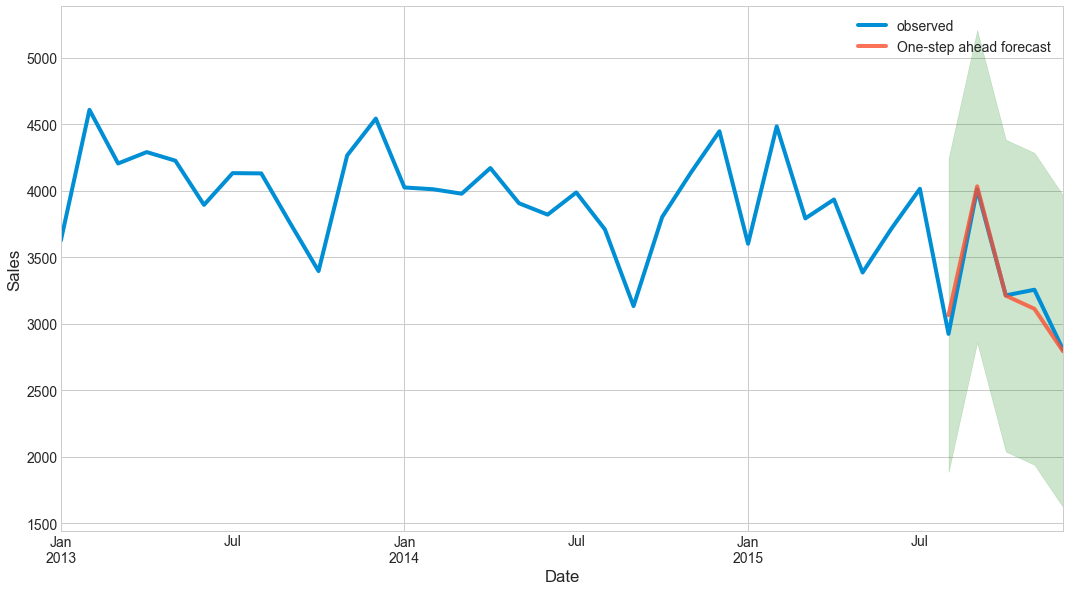

In [248]:
plt.style.use(['fivethirtyeight', 'seaborn-whitegrid'])
pre = results.get_prediction(start = pd.to_datetime('2015-08-01'), dynamic = False)
pre_ci = pre.conf_int()

ax = y['2013-01-01':].plot(label = 'observed')

pre.predicted_mean.plot(ax = ax, 
                       label = 'One-step ahead forecast',
                       alpha = .8,
                       figsize = (16, 9))

ax.fill_between(pre_ci.index,
               pre_ci.iloc[:, 0],
               pre_ci.iloc[:, 1],
               color = 'g', alpha = .2)

ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

In [250]:
y_forecast = pre.predicted_mean
y_actual = y['2015-01-01':]

mse = ((y_forecast - y_actual) ** 2).mean()
print('RMSE {}'.format(round(np.sqrt(mse), 2)))

RMSE 90.58


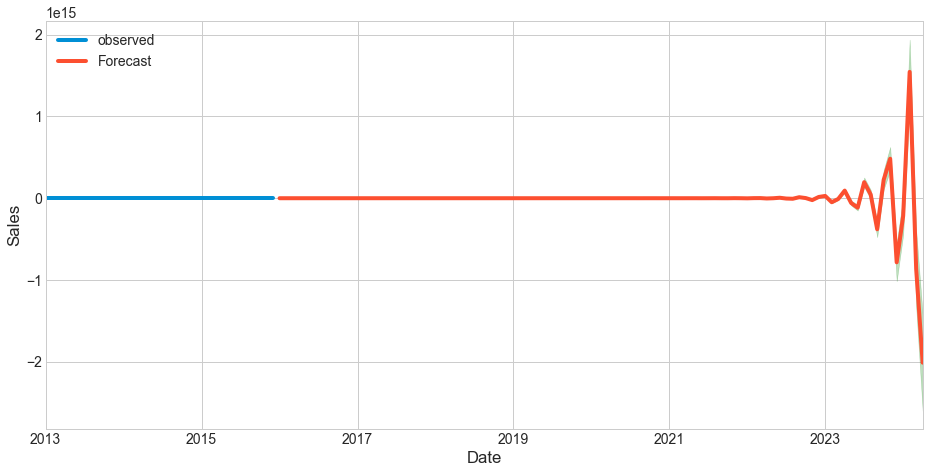

In [251]:
pre_uc = results.get_forecast(steps=100)
pre_ci = pre_uc.conf_int()

ax = y.plot(label='observed', figsize=(14, 7))
pre_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pre_ci.index,
                pre_ci.iloc[:, 0],
                pre_ci.iloc[:, 1], color='g', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')

plt.legend()
plt.show()

In [198]:
s1 = data.loc[(data.Store == 1)]
s2 = data.loc[(data.Store == 2)]
s3 = data.loc[(data.Store == 3)]

s1 = s1.groupby('Date')['Sales'].sum().reset_index()
s2 = s2.groupby('Date')['Sales'].sum().reset_index()
s3 = s3.groupby('Date')['Sales'].sum().reset_index()

s1['Date'] = pd.to_datetime(s1['Date'])
s2['Date'] = pd.to_datetime(s2['Date'])
s3['Date'] = pd.to_datetime(s3['Date'])

s1 = s1.set_index('Date')
s2 = s2.set_index('Date')
s3 = s3.set_index('Date')

s1_y = s1['Sales'].resample('MS').mean()
s2_y = s2['Sales'].resample('MS').mean()
s3_y = s3['Sales'].resample('MS').mean()

s1 = pd.DataFrame({'Date': s1_y.index, 
                  'Sales': s1_y.values})

s2 = pd.DataFrame({'Date': s2_y.index, 
                  'Sales': s2_y.values})

s3 = pd.DataFrame({'Date': s3_y.index, 
                  'Sales': s3_y.values})

stores = s1.merge(s2, how = 'inner', 
                  on = 'Date')

stores = stores.merge(s3, how = 'inner',
                      on = 'Date')

stores.head()

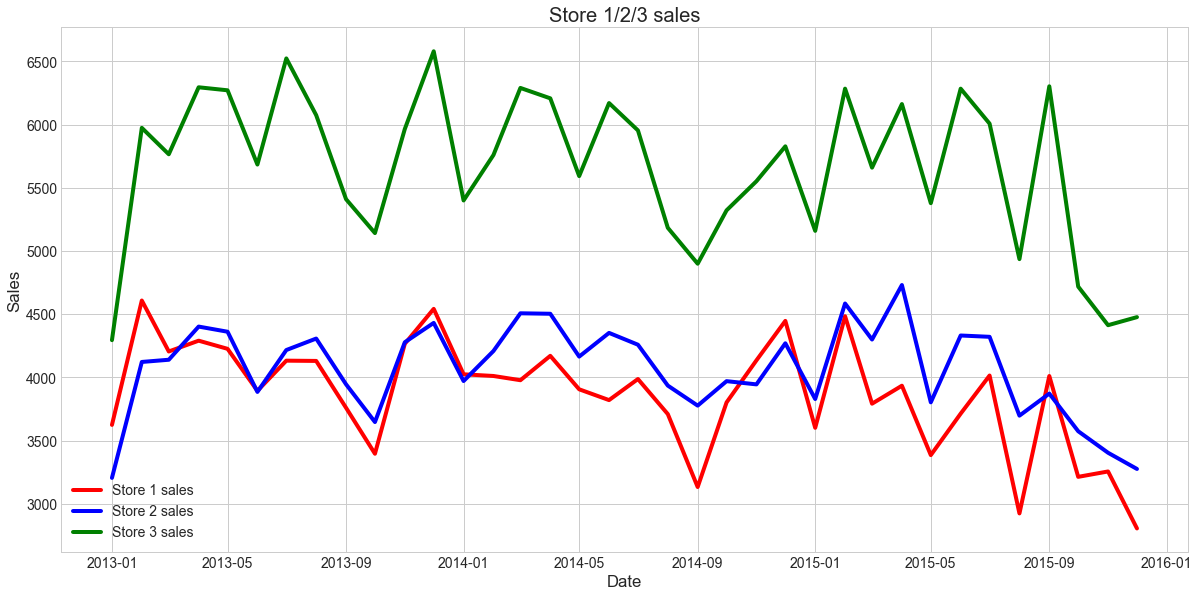

In [205]:
stores.rename(columns = {'Sales_x': 'Store_1',  
                         'Sales_y': 'Store_2',
                         'Sales': 'Store_3'},
             inplace = True)

#stores.head()

plt.figure(figsize = (18, 9))

plt.plot(stores['Date'], stores['Store_1'], 
         'r-', label = 'Store 1 sales')

plt.plot(stores['Date'], stores['Store_2'], 
         'b-', label = 'Store 2 sales')

plt.plot(stores['Date'], stores['Store_3'], 
         'g-', label = 'Store 3 sales')


plt.xlabel('Date')
plt.ylabel('Sales')

plt.title('Store 1/2/3 sales')

plt.legend();

## 1, 2 & 3 have similar seasonal patterns 

In [312]:
# DFs & fitting 
sales1 = stores.rename(columns = {'Date': 'ds', 
                                   'Store_1': 'y'})
sales1_pro = Prophet(interval_width = .95)
sales1_pro.fit(sales1)

sales2 = stores.rename(columns = {'Date': 'ds', 
                                   'Store_2': 'y'})
sales2_pro = Prophet(interval_width = .95)
sales2_pro.fit(sales2)

sales3 = stores.rename(columns = {'Date': 'ds', 
                                   'Store_3': 'y'})
sales3_pro = Prophet(interval_width = .95)
sales3_pro.fit(sales3)

# Forecasts
sales1_forecast = sales1_pro.make_future_dataframe(periods = 12,
                                                   freq = 'M')
sales1_forecast = sales1_pro.predict(sales1_forecast)

sales2_forecast = sales2_pro.make_future_dataframe(periods = 12,
                                                   freq = 'M')
sales2_forecast = sales2_pro.predict(sales2_forecast)

sales3_forecast = sales3_pro.make_future_dataframe(periods = 12,
                                                   freq = 'M')
sales3_forecast = sales3_pro.predict(sales3_forecast)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\ke117\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\ke117\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override th

<Figure size 360x1440 with 0 Axes>

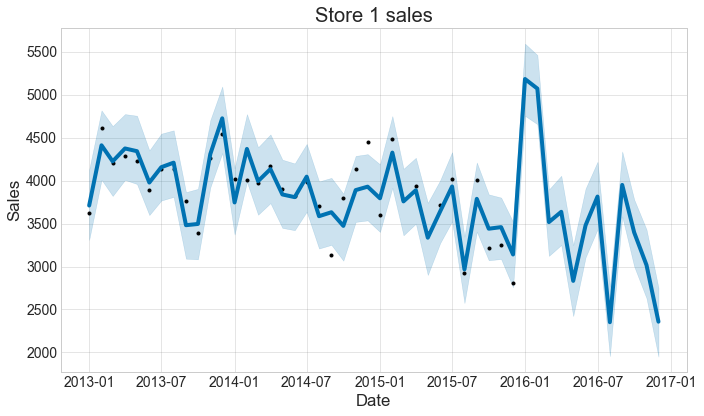

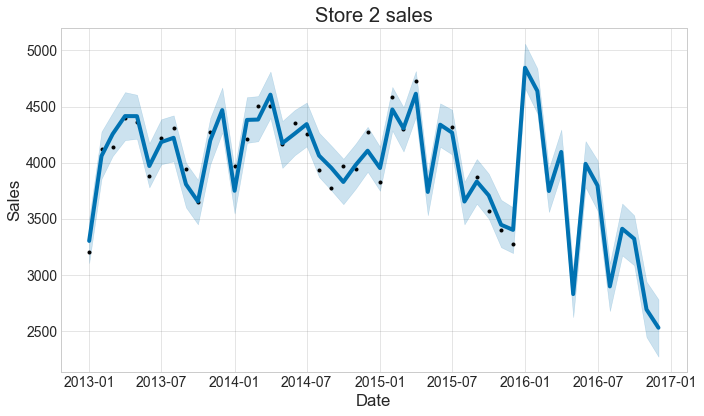

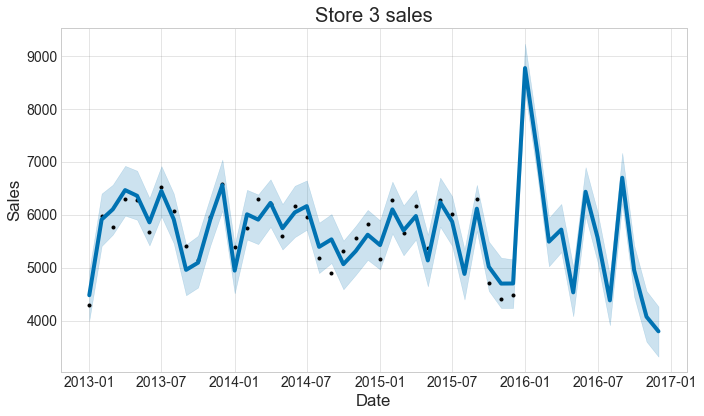

In [313]:
plt.figure(figsize = (5, 20))
plt.style.use(['fivethirtyeight', 'seaborn-whitegrid'])

sales1_pro.plot(sales1_forecast, 
              xlabel = 'Date',
              ylabel = 'Sales')
plt.title('Store 1 sales')

plt.tight_layout();

sales2_pro.plot(sales2_forecast, 
              xlabel = 'Date',
              ylabel = 'Sales')
plt.title('Store 2 sales')

plt.tight_layout(); 

sales3_pro.plot(sales3_forecast, 
              xlabel = 'Date',
              ylabel = 'Sales')
plt.title('Store 3 sales')

plt.tight_layout(); 

In [314]:
store1 = ['store_1%s' % column for column in sales1_forecast.columns]
store2 = ['store_2%s' % column for column in sales2_forecast.columns]
store3 = ['store_3%s' % column for column in sales3_forecast.columns]

merge_store1_forecast = sales1_forecast.copy()
merge_store2_forecast = sales2_forecast.copy()
merge_store3_forecast = sales3_forecast.copy()

merge_store1_forecast.columns = store1
merge_store2_forecast.columns = store2
merge_store3_forecast.columns = store3

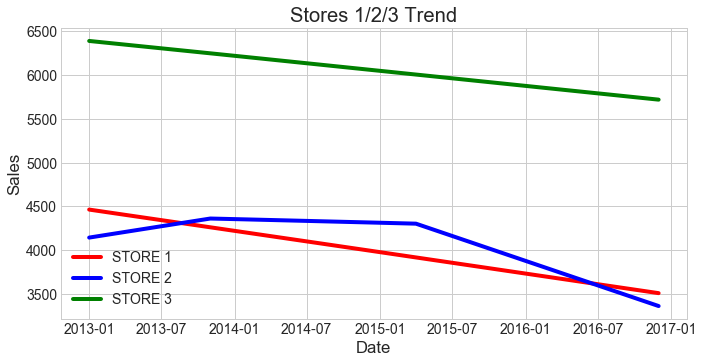

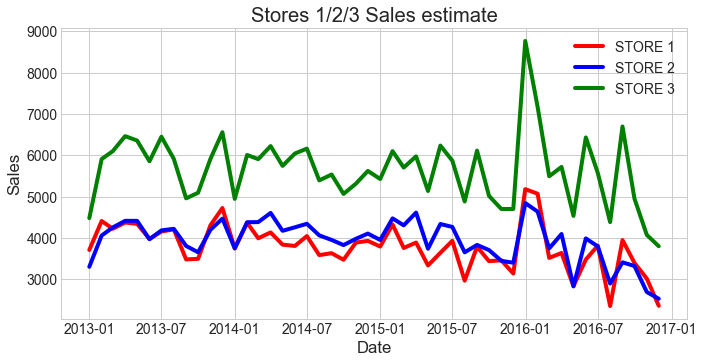

In [315]:
forecasts = pd.merge(merge_store1_forecast,
                    merge_store2_forecast,
                    how = 'inner',
                    left_on = 'store_1ds',
                    right_on = 'store_2ds')
forecasts = forecasts.rename(columns = {'store_1ds':'Date'}).drop('store_2ds', axis = 1)

forecasts = pd.merge(forecasts,
                    merge_store3_forecast,
                    how = 'inner',
                    left_on = 'Date',
                    right_on = 'store_3ds')

forecasts = forecasts.rename(columns = {'store_1ds':'Date'}).drop('store_3ds', axis = 1)

plt.figure(figsize = (10, 5))
plt.plot(forecasts['Date'], forecasts['store_1trend'], 'r-', label = 'STORE 1')
plt.plot(forecasts['Date'], forecasts['store_2trend'], 'b-', label = 'STORE 2')
plt.plot(forecasts['Date'], forecasts['store_3trend'], 'g-', label = 'STORE 3')

plt.xlabel('Date') ; plt.ylabel('Sales')
plt.title('Stores 1/2/3 Trend')
plt.legend()

plt.figure(figsize = (10, 5))
plt.plot(forecasts['Date'], forecasts['store_1yhat'], 'r-', label = 'STORE 1')
plt.plot(forecasts['Date'], forecasts['store_2yhat'], 'b-', label = 'STORE 2')
plt.plot(forecasts['Date'], forecasts['store_3yhat'], 'g-', label = 'STORE 3')

plt.xlabel('Date') ; plt.ylabel('Sales')
plt.title('Stores 1/2/3 Sales estimate')
plt.legend()

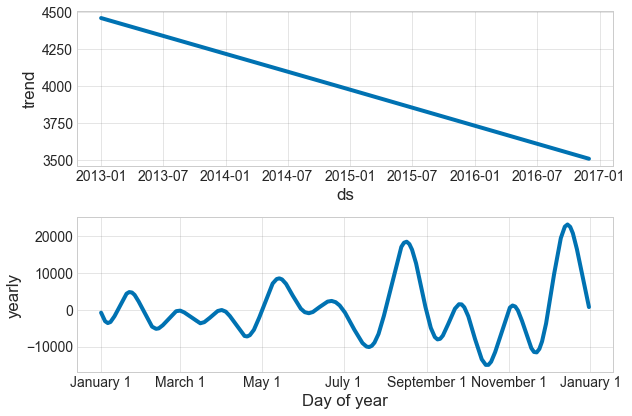

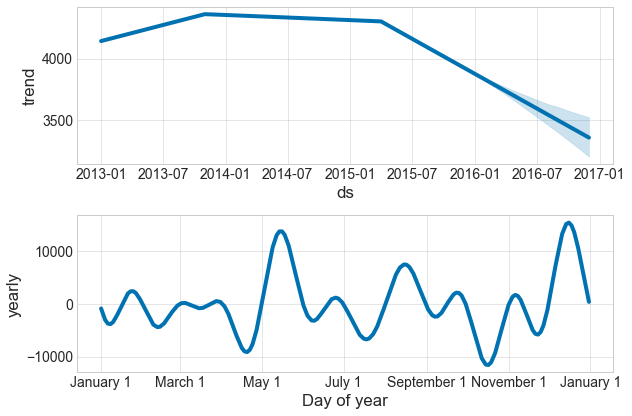

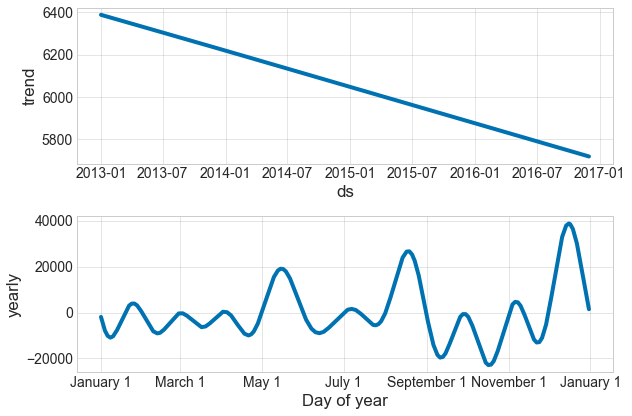

In [318]:
sales1_pro.plot_components(sales1_forecast);
sales2_pro.plot_components(sales2_forecast);
sales3_pro.plot_components(sales3_forecast);

# LSTM 

# resample over day 
df.set_index('Date', inplace = True)
df['Sales'] = df['Sales'].resample('D').mean()
#df = df['Sales'].resample('D').mean()

In [65]:
df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,quarter,weekday,year,month,day,week_of_year,day_of_year,day_of_week,IsStateHoliday,Day
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,5,9067.033184,555,1,1,0,1,c,a,...,3,1,2015,7,31,31,212,4,0,Weekday
2015-07-30,1,4,7891.348879,546,1,1,0,1,c,a,...,3,1,2015,7,30,31,211,3,0,Weekday
2015-07-29,1,3,7623.284305,523,1,1,0,1,c,a,...,3,1,2015,7,29,31,210,2,0,Weekday
2015-07-28,1,2,8174.953363,560,1,1,0,1,c,a,...,3,1,2015,7,28,31,209,1,0,Weekday
2015-07-27,1,1,9602.952466,612,1,1,0,1,c,a,...,3,1,2015,7,27,31,208,0,0,Weekday


data = df.Sales.values #numpy.ndarray
data = data.astype('float32')
data = np.reshape(data, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
train_size = int(len(data) * 0.80)
test_size = len(data) - train_size
train, test = data[0:train_size,:], data[train_size:len(data),:]

def create_data(data, look_back=1):
    X, Y = [], []
    for i in range(len(data)-look_back-1):
        a = data[i:(i+look_back), 0]
        X.append(a)
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 30
X_train, Y_train = create_data(train, look_back)
X_test, Y_test = create_data(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=5, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()

# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

# Last 48 days 
aa=[x for x in range(211)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:211], marker='.', label="actual")
# compare actual & predicted for last 48 days 
plt.plot(aa, test_predict[:,0][:211], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Sales', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

### Each step = 1 day 
- resampled over 1 day 